In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler

def generate_single_ar3_series(n=10000, var=0.000211, seed=None):
    """
    Generates a time series using a single AR(3) process and calculates drawdown metrics.

    Args:
        n (int): Number of observations to generate.
        var (float): Variance of the white noise (at).
        seed (int): Random seed for reproducibility.

    Returns:
        pd.DataFrame: A DataFrame with columns 'ar3', 'duration', and 'magnitude'.
    """
    if seed is not None:
        np.random.seed(seed)

    # AR(3) coefficients
    f0, f1, f2, f3 = 0.25, 0.2, 0.35, -0.1
    noise = np.random.normal(0, np.sqrt(var), n)

    # Initialize the time series
    rt = np.zeros(n)
    rt[:3] = [0.032, 0.020, -0.042]  # Initial values

    # Generate the time series
    for t in range(3, n):
        rt[t] = f0 + f1 * rt[t - 1] + f2 * rt[t - 2] + f3 * rt[t - 3] + noise[t]

    # Calculate drawdown metrics
    max_so_far = rt[0]
    duration = 0
    magnitudes = []
    durations = []

    for i in range(n):
        if rt[i] >= max_so_far:
            max_so_far = rt[i]
            duration = 0  # Reset duration since no drawdown
        else:
            duration += 1

        # Compute magnitude as percentage drop from max_so_far
        magnitude = (max_so_far - rt[i]) / max_so_far if max_so_far != 0 else 0
        magnitudes.append(magnitude)
        durations.append(duration)

    # Create the DataFrame
    df = pd.DataFrame({
        'ar3': rt,
        'magnitude': magnitudes,
        'duration': durations
    })

    return df


def generate_dual_ar3_series(n=10000, var=0.000211, seed=None):
    
    if seed is not None:
        np.random.seed(seed)

    # AR(3) coefficients for the two regimes
    f0, f1, f2, f3 = 0.25, 0.2, 0.35, -0.1  # Regular regime
    f0_alt, f1_alt, f2_alt, f3_alt = 0.0001, 0.25, 0.2, 0.35  # Poor fit regime
    noise = np.random.normal(0, np.sqrt(var), n)

    # Initialize the time series
    rt = np.zeros(n)
    rt[:3] = [0.032, 0.020, -0.042]  # Initial values

    # Generate the time series with regime shifts
    for t in range(3, n):
        if (t // 30) % 2 == 0:  # Every 30 observations, decide the regime
            rt[t] = f0 + f1 * rt[t-1] + f2 * rt[t-2] + f3 * rt[t-3] + noise[t]
        else:
            rt[t] = (
                    f0_alt
                    + f1_alt * rt[t-1]
                    + f2_alt * rt[t-2]
                    + f3_alt * rt[t-3]
                    + noise[t]
            )

    # Calculate drawdown metrics
    max_so_far = rt[0]
    duration = 0
    magnitudes = []
    durations = []

    for i in range(n):
        if rt[i] >= max_so_far:
            max_so_far = rt[i]
            duration = 0  # Reset duration since no drawdown
        else:
            duration += 1

        # Compute magnitude as percentage drop from max_so_far
        magnitude = (max_so_far - rt[i]) / max_so_far if max_so_far != 0 else 0
        magnitudes.append(magnitude)
        durations.append(duration)

    # Create the DataFrame
    df = pd.DataFrame({
        'ar3': rt,
        'magnitude': magnitudes,
        'duration': durations
    })

    return df

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler

def generate_single_ar3_series(n=10000, var=0.000211, seed=None, window=10):
    """
    Generates a time series using a single AR(3) process and calculates:
      - global magnitude / duration (full drawdown),
      - local magnitude (rolling average of global magnitude),
      - local duration (based on local max within a rolling window).

    Args:
        n (int): Number of observations to generate.
        var (float): Variance of the white noise (at).
        seed (int): Random seed for reproducibility.
        window (int): Rolling window size for local drawdown metrics.

    Returns:
        pd.DataFrame: DataFrame with columns:
          'ar3', 'magnitude', 'duration',
          'local_magnitude', 'local_duration'.
    """
    if seed is not None:
        np.random.seed(seed)

    # AR(3) coefficients
    f0, f1, f2, f3 = 0.25, 0.2, 0.35, -0.1
    noise = np.random.normal(0, np.sqrt(var), n)

    # Initialize the time series
    rt = np.zeros(n)
    rt[:3] = [0.032, 0.020, -0.042]  # Initial values

    # Generate the time series
    for t in range(3, n):
        rt[t] = f0 + f1 * rt[t - 1] + f2 * rt[t - 2] + f3 * rt[t - 3] + noise[t]

    # ---------------------------------------------------------------------
    # 1) Calculate "global" drawdown metrics (magnitude, duration)
    # ---------------------------------------------------------------------
    max_so_far = rt[0]
    duration = 0
    magnitudes = []
    durations = []

    for i in range(n):
        if rt[i] >= max_so_far:
            max_so_far = rt[i]
            duration = 0  # Reset duration since no drawdown
        else:
            duration += 1

        # Compute magnitude as percentage drop from max_so_far
        magnitude = (max_so_far - rt[i]) / max_so_far if max_so_far != 0 else 0
        magnitudes.append(magnitude)
        durations.append(duration)

    df = pd.DataFrame({
        'ar3': rt,
        'magnitude': magnitudes,
        'duration': durations
    })

    # ---------------------------------------------------------------------
    # 2) Compute "local" magnitude (rolling average of global magnitude)
    # ---------------------------------------------------------------------
    df['local_magnitude'] = df['magnitude'].rolling(
        window=window,
        min_periods=1
    ).mean()

    # ---------------------------------------------------------------------
    # 3) Compute "local" duration
    #
    #   For each i, look back `window` points (or up to i=0 if near start),
    #   find the local max in that window.
    #   If ar3[i] < local_max, we increment local_duration by 1 (i.e.,
    #   continuing a local drawdown). If ar3[i] == local_max, reset to 0.
    # ---------------------------------------------------------------------
    local_duration = np.zeros(n, dtype=int)

    for i in range(n):
        # define the rolling window [start, i]
        start_idx = max(0, i - window + 1)
        # local max in this rolling window
        local_max = np.max(rt[start_idx : i+1])

        if rt[i] < local_max:
            # still in a local drawdown
            if i > 0:
                local_duration[i] = local_duration[i - 1] + 1
            else:
                local_duration[i] = 1
        else:
            # new local max or exactly equal to local max => reset
            local_duration[i] = 0

    df['local_duration'] = local_duration

    return df

In [3]:
def generate_dual_ar3_series(n=10000, var=0.000211, seed=None, window=10):
    """
    Generates a time series using two regimes of AR(3) processes with regime shifts
    every 30 observations, and calculates:
      - global magnitude / duration (full drawdown),
      - local magnitude (rolling average of global magnitude),
      - local duration (based on local max within a rolling window).

    Args:
        n (int): Number of observations to generate.
        var (float): Variance of the white noise (at).
        seed (int): Random seed for reproducibility.
        window (int): Rolling window size for local drawdown metrics.

    Returns:
        pd.DataFrame: DataFrame with columns:
          'ar3', 'magnitude', 'duration',
          'local_magnitude', 'local_duration'.
    """
    if seed is not None:
        np.random.seed(seed)

    # AR(3) coefficients for the two regimes
    f0, f1, f2, f3 = 0.25, 0.2, 0.35, -0.1  # Regular regime
    f0_alt, f1_alt, f2_alt, f3_alt = 0.0001, 0.25, 0.2, 0.35  # Alternate regime
    noise = np.random.normal(0, np.sqrt(var), n)

    # Initialize the time series
    rt = np.zeros(n)
    rt[:3] = [0.032, 0.020, -0.042]  # Initial values

    # Generate the time series with regime shifts
    for t in range(3, n):
        # Switch regimes every 30 observations
        if (t // 30) % 2 == 0:
            # Regular regime
            rt[t] = f0 + f1 * rt[t-1] + f2 * rt[t-2] + f3 * rt[t-3] + noise[t]
        else:
            # Alternate regime
            rt[t] = (
                    f0_alt
                    + f1_alt * rt[t-1]
                    + f2_alt * rt[t-2]
                    + f3_alt * rt[t-3]
                    + noise[t]
            )

    # ---------------------------------------------------------------------
    # 1) Calculate "global" drawdown metrics (magnitude, duration)
    # ---------------------------------------------------------------------
    max_so_far = rt[0]
    duration = 0
    magnitudes = []
    durations = []

    for i in range(n):
        if rt[i] >= max_so_far:
            max_so_far = rt[i]
            duration = 0
        else:
            duration += 1

        magnitude = (max_so_far - rt[i]) / max_so_far if max_so_far != 0 else 0
        magnitudes.append(magnitude)
        durations.append(duration)

    df = pd.DataFrame({
        'ar3': rt,
        'magnitude': magnitudes,
        'duration': durations
    })

    # ---------------------------------------------------------------------
    # 2) Compute "local" magnitude (rolling average of global magnitude)
    # ---------------------------------------------------------------------
    df['local_magnitude'] = df['magnitude'].rolling(
        window=window,
        min_periods=1
    ).mean()

    # ---------------------------------------------------------------------
    # 3) Compute "local" duration
    # ---------------------------------------------------------------------
    local_duration = np.zeros(n, dtype=int)

    for i in range(n):
        start_idx = max(0, i - window + 1)
        local_max = np.max(rt[start_idx : i+1])

        if rt[i] < local_max:
            if i > 0:
                local_duration[i] = local_duration[i - 1] + 1
            else:
                local_duration[i] = 1
        else:
            local_duration[i] = 0

    df['local_duration'] = local_duration

    return df


In [4]:
class PrimaryModelRuleBased:
    def __init__(self):
        self.previous_position = 0  # Start with no position

    def predict(self, returns):
        """
        Generate positions based on the rule:
        y_t = 1 if Δr_t > 0, 0 if Δr_t < 0, else y_(t-1).
        
        Args:
            returns (np.ndarray): Time series of returns (r_t).
        
        Returns:
            np.ndarray: Generated positions (y_t).
        """
        positions = np.zeros(len(returns))
        for t in range(1, len(returns)):
            delta_r = returns[t] - returns[t - 1]
            if delta_r > 0:
                positions[t] = 1  # Go long
            elif delta_r < 0:
                positions[t] = 0  # Exit
            else:
                positions[t] = positions[t - 1]  # Keep previous position
        return positions

In [5]:
class MetaLabelingModel:
    def __init__(self, X_meta, y_meta, threshold):
        self.secondary_model = GradientBoostingClassifier(random_state=42)
        self.scaler = MinMaxScaler()
        self.threshold = threshold
        self.X_meta = X_meta
        self.y_meta = y_meta

    def fit(self):
        # Normalize the features for meta-labeling
        self.X_meta = self.scaler.fit_transform(self.X_meta)
        self.secondary_model.fit(self.X_meta, self.y_meta)

    def predict(self):
        # Predict probabilities for meta-labeling
        probabilities = self.secondary_model.predict_proba(self.X_meta)[:, 1]  # Get probability for class 1
        return probabilities

#TODO: Anpassungen
    def bet_sizing(self, probabilities):
        # Apply the threshold for final output
        return np.where(probabilities >= self.threshold, 1, 0)

In [6]:
def run_model(include_drawdowns: bool, regime: bool, window: int = 10):
    if regime:
        data = generate_dual_ar3_series(n=10000, window=window)
    else:
        data = generate_single_ar3_series(n=10000)

    primary_model = PrimaryModelRuleBased()
    primary_output = primary_model.predict(data['ar3'])

    if include_drawdowns:
        X_meta = data.to_numpy()
    else:
        X_meta = data['ar3'].to_numpy().reshape(-1,1)
    y_meta = primary_output

    meta_model = MetaLabelingModel(X_meta, y_meta, threshold=0.9)

    meta_model.fit()

    meta_output = meta_model.predict()
    final_output = meta_model.bet_sizing(meta_output)

    # Calculate the returns from the model's decisions
    strategy_returns = final_output * np.diff(data['ar3'], prepend=0)  # Strategy returns based on positions

    # Calculate the Sharpe Ratio
    mean_return = np.mean(strategy_returns)
    std_return = np.std(strategy_returns)

    # Assume risk-free rate is 0 for simplicity
    risk_free_rate = 0
    sharpe_ratio = (mean_return - risk_free_rate) / std_return

    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

    return sharpe_ratio

In [ ]:
model_runs_including_drawdowns = []
#model_runs_without_drawdowns = []

for i in range(1,101):
    window_i = []
    for j in range(1,101):
        window_i.append(run_model(True, False, i))
        #model_runs_without_drawdowns.append(run_model(False, False))
    model_runs_including_drawdowns.append(np.mean(window_i))

In [11]:
model_runs_including_drawdowns_including_regimes = []
model_runs_without_drawdowns_including_regimes = []
model_runs_including_drawdowns_no_regimes = []
model_runs_without_drawdowns_no_regimes = []

for i in range(1,101):
    model_runs_including_drawdowns_including_regimes.append(run_model(True, True))
    model_runs_without_drawdowns_including_regimes.append(run_model(False, True))
    model_runs_including_drawdowns_no_regimes.append(run_model(True, False))
    model_runs_without_drawdowns_no_regimes.append(run_model(False,False))

Sharpe Ratio: 0.2591
Sharpe Ratio: 0.1644
Sharpe Ratio: 0.3507
Sharpe Ratio: 0.1935
Sharpe Ratio: 0.2590
Sharpe Ratio: 0.1544
Sharpe Ratio: 0.3301
Sharpe Ratio: 0.1710
Sharpe Ratio: 0.2561
Sharpe Ratio: 0.1680
Sharpe Ratio: 0.3283
Sharpe Ratio: 0.1951
Sharpe Ratio: 0.2583
Sharpe Ratio: 0.1441
Sharpe Ratio: 0.3396
Sharpe Ratio: 0.2141
Sharpe Ratio: 0.2566
Sharpe Ratio: 0.1124
Sharpe Ratio: 0.3415
Sharpe Ratio: 0.1630
Sharpe Ratio: 0.2612
Sharpe Ratio: 0.1528
Sharpe Ratio: 0.3255
Sharpe Ratio: 0.1964
Sharpe Ratio: 0.2555
Sharpe Ratio: 0.1493
Sharpe Ratio: 0.3455
Sharpe Ratio: 0.2141
Sharpe Ratio: 0.2549
Sharpe Ratio: 0.1227
Sharpe Ratio: 0.3257
Sharpe Ratio: 0.2080
Sharpe Ratio: 0.2587
Sharpe Ratio: 0.1118
Sharpe Ratio: 0.3444
Sharpe Ratio: 0.1858
Sharpe Ratio: 0.2535
Sharpe Ratio: 0.1053
Sharpe Ratio: 0.3299
Sharpe Ratio: 0.1877
Sharpe Ratio: 0.2566
Sharpe Ratio: 0.1246
Sharpe Ratio: 0.3341
Sharpe Ratio: 0.1835
Sharpe Ratio: 0.2556
Sharpe Ratio: 0.1630
Sharpe Ratio: 0.3226
Sharpe Ratio:

In [12]:
print(f"Y Regimes Y Drawdown {np.mean(model_runs_including_drawdowns_including_regimes):.4f}")
print(f"Y Regimes N Drawdown {np.mean(model_runs_without_drawdowns_including_regimes):.4f}")
print(f"N Regimes Y Drawdown {np.mean(model_runs_including_drawdowns_no_regimes):.4f}")
print(f"N Regimes N Drawdown {np.mean(model_runs_without_drawdowns_no_regimes):.4f}")

Y Regimes Y Drawdown 0.2570
Y Regimes N Drawdown 0.1316
N Regimes Y Drawdown 0.3354
N Regimes N Drawdown 0.1999


In [30]:
np.mean(model_runs_including_drawdowns)

np.float64(0.33405355463711994)

In [31]:
#np.mean(model_runs_without_drawdowns)

np.float64(0.2006894531407094)

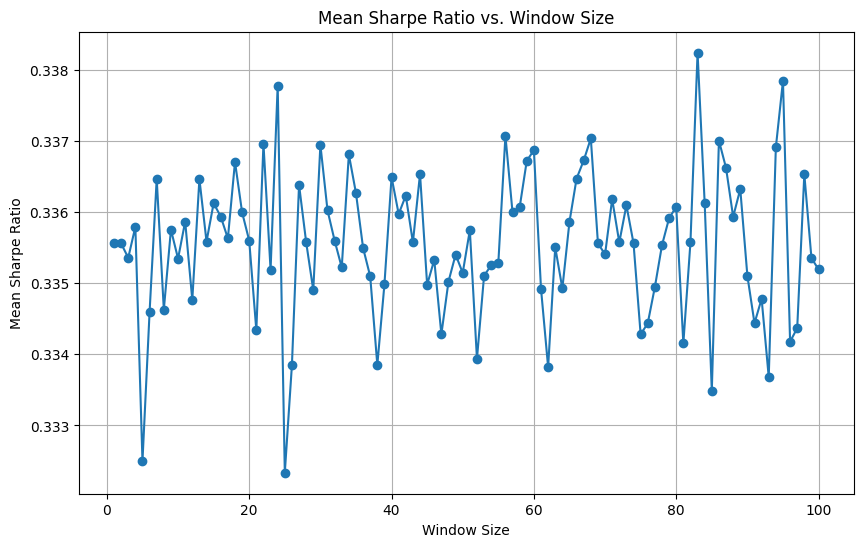

In [35]:
import matplotlib.pyplot as plt
import numpy as np

window_sizes = range(1, 101)  # x-axis values

plt.figure(figsize=(10, 6))
plt.plot(window_sizes, model_runs_including_drawdowns, marker='o')
plt.title("Mean Sharpe Ratio vs. Window Size")
plt.xlabel("Window Size")
plt.ylabel("Mean Sharpe Ratio")
plt.grid(True)
plt.show()